## Imports

In [60]:
import os
import json
import pysam
import gcsfs
import tarfile
import upsetplot

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

from google.cloud import storage
from collections import Counter
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from tabulate import tabulate
from IPython.core.display import display, HTML

/tmp/ipykernel_73/3757731684.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [61]:
# ! pip install upsetplot

## Constants

### User Inputs

In [62]:
use_cache = True

# subset = "joint_extracted_truth_raw_cnv_excluded_defrag_eval_vFixed"
subset = "raw_cnv_excluded_defrag_truth_joint_extracted_eval_vFixed"

min_size_cache = None
max_size_cache = None
valid_types_cache = ["DEL", "DUP", "INS", "INV", "BND", "CNV", "CPX"]

min_size_filter = 5000
max_size_filter = None
valid_types_filter = ["DEL", "DUP", "CNV"]

sr_callers = ["depth", "dragen", "scramble", "wham"]
    
info_fields = ["AF", "STRAT", "TRUTH_VID"]

format_fields = ["GT", "GQ", "SL"]

### Additional

In [63]:
in_dir = f"/home/jupyter/Files/inputs/concordance_sample"
out_dir = f"/home/jupyter/Files/outputs/concordance_sample"
os.makedirs(out_dir, exist_ok=True)

input_file_path = os.path.join(in_dir, f"{subset}.vcf.gz")
output_file_path = os.path.join(out_dir, f"{subset}.tsv")
cached_df_path = os.path.join(out_dir, f"{subset}.cached.tsv")

palette = sns.set_palette("muted")

In [64]:
chrom_order = {f'chr{i}': i for i in range(1, 23)}
chrom_order.update({'chrX': 23, 'chrY': 24})

## Helper Functions

In [65]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [66]:
def assign_status(val):
    if 'TP' in val:
        return 1
    elif any(x in val for x in ['FP', 'FN', 'EMPTY']):
        return 0
    else:
        raise Exception(f"{val} is an unexpected CONC_ST type - please resolve.")

In [67]:
def compute_summary(df, n_samples, support_val=1, pre_filter=False, filter_col=None, filter_val=None, filter_col2=None, filter_val2=None):
    df_filtered = df[df[filter_col] == filter_val] if pre_filter else df
    if filter_col2 is not None and filter_val2 is not None:
        df_filtered = df_filtered[df_filtered[filter_col2] == filter_val2]
    
    calls_count = df_filtered.shape[0]
    calls_supported_count = df_filtered[df_filtered["STATUS_SAMPLE"] >= support_val].shape[0]
    
    calls_per_genome = round(calls_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_per_genome = round(calls_supported_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_proportion = f"{round((calls_supported_count / calls_count) * 100, 2)}%" if calls_count > 0 else 0
    
    filter_val = f"{filter_val} + {filter_val2}" if filter_col2 is not None and filter_val2 is not None else filter_val
    return [ filter_val, calls_per_genome, calls_supported_per_genome, calls_supported_proportion ]

In [68]:
def plot_hist(data, x, bins=20, palette=palette, **kwargs):    
    g = sns.displot(
        data, x=x,
        multiple="stack",
        edgecolor=".3",
        linewidth=0.5,
        height=3, aspect=1.7,
        bins=bins,
        **kwargs
    )    
    
    if str(data[x].dtype) == "object" or isinstance(data[x].dtype, pd.CategoricalDtype):
        rotation = 90
        for ax in g.fig.axes:
            ax.set_xticks(range(len(data[x].cat.categories)))
            ax.set_xticklabels(data[x].cat.categories, rotation=rotation)

In [69]:
def plot_averaged_hist(data, group_col, support_col="SUPPORT", **kwargs):
    df_plot = data.copy()
    plot_support_col = support_col
    
    grouped = df_plot.groupby([group_col, plot_support_col]).size().unstack(fill_value=0)
    
    ax = grouped.plot(kind="bar", stacked=True, **kwargs)
    ax.set_xlabel(group_col)
    ax.set_ylabel("Calls") 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        group_idx = int(x + width/2)
        total = grouped.iloc[group_idx].sum()
        if total > 0:
            percent = height / total * 100
            label = f"{percent:.2f}%"
            if height < 100:
                offset = 0.02
                ax.text(x + width + offset, y + height/2, label, ha="left", va="center", color="black", fontsize=9)
            else:
                ax.text(x + width/2, y + height/2, label, ha="center", va="center", color="black", fontsize=9)
                
    totals = grouped.sum(axis=1)
    ylim = ax.get_ylim()
    offset = (ylim[1] - ylim[0]) * 0.01
    xticks = ax.get_xticks()
    for i, total in enumerate(totals):
        ax.text(xticks[i], total + offset, f"{int(round(total))}", ha="center", va="bottom", fontsize=12)
    
    plt.tight_layout()
    plt.show()

## Process

### Verification

In [70]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [71]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [72]:
# Load concordance VCF

if not use_cache:
    gcs_client = storage.Client()
    
    with open(output_file_path, "w") as tsv:
        pass
    
    with pysam.VariantFile(input_file_path) as vcf, open(output_file_path, "a") as tsv:
        tsv.write(
            "\t".join(
                ["VID", "SAMPLE", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS_SITE", "STATUS_SAMPLE"]
                + [sc.upper() for sc in sr_callers]
                + format_fields
                + info_fields
            )
            + "\n"
        )
        
        for r in vcf:
            svtype = r.info.get("SVTYPE", None)
            svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
            svlen = -1 if svlen == 0 else svlen
            filters = ",".join(f for f in r.filter)

            if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
            
            if max_size_cache is not None:
                if svlen > max_size_cache:
                    continue

            if min_size_cache is not None:
                if svlen < min_size_cache:
                    continue
                    
            row_data = []
            for s in r.samples:
                if _is_non_ref(r.samples[s]["GT"]):
                    base = [
                        r.id,
                        s,
                        r.chrom,
                        r.pos,
                        svtype,
                        svlen,
                        filters,
                        1 if r.info.get("STATUS", "") == "TP" else 0,
                        r.samples[s].get("CONC_ST")
                    ]

                    algos = r.info.get("ALGORITHMS", [])
                    if isinstance(algos, str):
                        algos = [algos]

                    sr_flags = []
                    for sc in sr_callers:
                        if sc in algos:
                            sr_flags.append(1)
                        else:
                            sr_flags.append(0)

                    fmts = [r.samples[s].get(k, None) for k in format_fields if k in format_fields]
                            
                    infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
                            
                    row_data.append(base + sr_flags + fmts + infs)
                    
            if row_data:
                for rd_ in row_data:
                    tsv.write("\t".join(str(x) for x in rd_) + "\n")

### Dataframe Processing

In [73]:
# Formatting

if not use_cache:
    df = pd.read_csv(output_file_path, sep="\t")

    # Set column types
    df = df.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df.columns:
        df["GQ"] = df["GQ"].astype(float)
    if "SL" in df.columns:
        df["SL"] = df["SL"].astype(float)
        
    # Process STATUS_SAMPLE
    df['STATUS_SAMPLE'] = df['STATUS_SAMPLE'].apply(assign_status)
        
    # Process AF
    df["AF"] = df["AF"].astype(str).str.replace(r"[(),]", "", regex=True).astype(float)

    # Process STRAT
    df['RM'] = df['STRAT'].str.contains('RM_', regex=False, na=False).astype(int)
    df['SD'] = df['STRAT'].str.contains('SD_', regex=False, na=False).astype(int)
    df['SR'] = df['STRAT'].str.contains('SR_', regex=False, na=False).astype(int)
    strat_map = {
        (1, 0, 0): "RM",
        (0, 1, 0): "SD",
        (0, 0, 1): "SR",
        (1, 1, 0): "RM+SD",
        (1, 0, 1): "RM+SR",
        (0, 1, 1): "SD+SR",
        (1, 1, 1): "RM+SD+SR"
    }
    df["STRAT"] = df[["RM", "SD", "SR"]].apply(lambda row: strat_map.get(tuple(row.tolist()), "Other"), axis=1)
        
    # Process categorical
    df['SVTYPE'] = pd.Categorical(df['SVTYPE'])
    
    df['STRAT'] = pd.Categorical(df['STRAT'])

In [74]:
# Enhancement

if not use_cache:
    # Set log_SVLEN
    df["log_SVLEN"] = np.log10(df["SVLEN"].where(df["SVLEN"] > 0, np.nan))

    # Set SIZE
    df["SIZE"] = df["SVLEN"]
    df.loc[df["SVTYPE"] == "DEL", "SIZE"] = -df.loc[df["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df["SRWGS"] = df.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df["SUPPORT"] = "SR"
    df.loc[(df["SRWGS"] == 1) & (df["STATUS_SAMPLE"] == 1), "SUPPORT"] = "SR Retained"
    df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

In [75]:
if not use_cache:
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [76]:
df = pd.read_csv(cached_df_path, sep="\t")

df.head()

,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,STATUS_SAMPLE,DEPTH,...,AF,STRAT,TRUTH_VID,RM,SD,SR,log_SVLEN,SIZE,SRWGS,SUPPORT
0,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,RGP_1012_2,chr1,12001,DUP,8001,MULTIALLELIC,0,0,1,...,0.251,SD,NaN,0,1,0,3.903144,8001,1,SR
1,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,RGP_101_1,chr1,12001,DUP,8001,MULTIALLELIC,0,0,1,...,0.251,SD,NaN,0,1,0,3.903144,8001,1,SR
2,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,RGP_101_2,chr1,12001,DUP,8001,MULTIALLELIC,0,0,1,...,0.251,SD,NaN,0,1,0,3.903144,8001,1,SR
3,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,RGP_101_3,chr1,12001,DUP,8001,MULTIALLELIC,0,0,1,...,0.251,SD,NaN,0,1,0,3.903144,8001,1,SR
4,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,RGP_1061_3,chr1,12001,DUP,8001,MULTIALLELIC,0,0,1,...,0.251,SD,NaN,0,1,0,3.903144,8001,1,SR


In [77]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

df['STRAT'] = pd.Categorical(df['STRAT'])

df["SUPPORT"] = df["SUPPORT"].replace({"SR": "Not Concordant", "SR Retained": "Concordant"})
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

conditions = [
    df["AF"] < 0.01,
    df["AF"] < 0.05,
    df["AF"] < 0.2,
    df["AF"] < 0.5
]
choices = [
    "AF < 1%",
    "1% ≤ AF < 5%",
    "5% ≤ AF < 20%",
    "20% ≤ AF < 50%"
]
df["AF_BUCKET"] = np.select(conditions, choices, default="AF > 50%")
df["AF_BUCKET"] = pd.Categorical(
    df["AF_BUCKET"],
    categories=["AF < 1%", "1% ≤ AF < 5%", "5% ≤ AF < 20%", "20% ≤ AF < 50%", "AF > 50%"],
    ordered=True
)

In [78]:
# Filtering
  
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
if valid_types_filter is not None:
    bef = len(df)
    df = df[df["SVTYPE"].isin(valid_types_filter)]
    print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Explicitly remove CNVs
bef = len(df)
df = df[~df['VID'].str.contains('CNV')]
print(f"[CNVs] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-PASS FILTER
# bef = len(df)
# df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
# print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-Caller variants
# caller = "DRAGEN" if run == "evaluation" else "MANTA"
# bef = len(df)
# df = df[df[caller] == 1]
# print(f"[{caller} only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

[SVLEN < Min Size] Dropped 3089 records (3.77%), now left with 78928.

[Invalid SVTYPE] Dropped 0 records (0.0%), now left with 78928.

[CNVs] Dropped 24914 records (31.57%), now left with 54014.



,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,STATUS_SAMPLE,DEPTH,...,STRAT,TRUTH_VID,RM,SD,SR,log_SVLEN,SIZE,SRWGS,SUPPORT,AF_BUCKET
59,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,RGP_1012_2,chr1,40001,DEL,60001,NaN,0,0,1,...,RM+SD,NaN,1,1,0,4.778158,-60001,1,Not Concordant,20% ≤ AF < 50%
60,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,RGP_1012_3,chr1,40001,DEL,60001,NaN,0,0,1,...,RM+SD,NaN,1,1,0,4.778158,-60001,1,Not Concordant,20% ≤ AF < 50%
61,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,RGP_1056_3,chr1,40001,DEL,60001,NaN,0,0,1,...,RM+SD,NaN,1,1,0,4.778158,-60001,1,Not Concordant,20% ≤ AF < 50%
62,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,RGP_1061_3,chr1,40001,DEL,60001,NaN,0,0,1,...,RM+SD,NaN,1,1,0,4.778158,-60001,1,Not Concordant,20% ≤ AF < 50%
63,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,RGP_1170_3,chr1,40001,DEL,60001,NaN,0,0,1,...,RM+SD,NaN,1,1,0,4.778158,-60001,1,Not Concordant,20% ≤ AF < 50%


## Analyze

### Results for SVLEN > 5KB

In [79]:
display(HTML("<style>.container { width:100% !important; }</style>"))

total_calls = df.shape[0]
print(f"Total Calls: {total_calls}")

total_sites = df['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

print("\nLR Caller Support >= i")
table_rows = []
for i in range(0, 2):
    table_rows.append(compute_summary(df, n_samples, support_val=i, filter_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVTYPE")
table_rows = []
for svtype in df["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="SVTYPE", filter_val=svtype))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVLEN")
svlen_bins = {
    "SVLEN < 10KB": df[df["SVLEN"] < 10000],
    "SVLEN 10-50KB": df[(df["SVLEN"] >= 10000) & (df["SVLEN"] <= 50000)],
    "SVLEN > 50KB": df[df["SVLEN"] > 50000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, n_samples, filter_val=label))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by STRAT")
table_rows = []
for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="STRAT", filter_val=strat))
print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

Total Calls: 54014
Total Unique Sites: 3247
Total Unique Samples: 235


LR Caller Support >= i
╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     229.85     │          229.85          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     229.85     │          73.67           │       32.05%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

LR Caller Support by SVTYPE
╒══════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  SVTYPE  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞══════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   DEL    │     169.08     │           66.6           │       39.39%        │
├──────────┼─────────

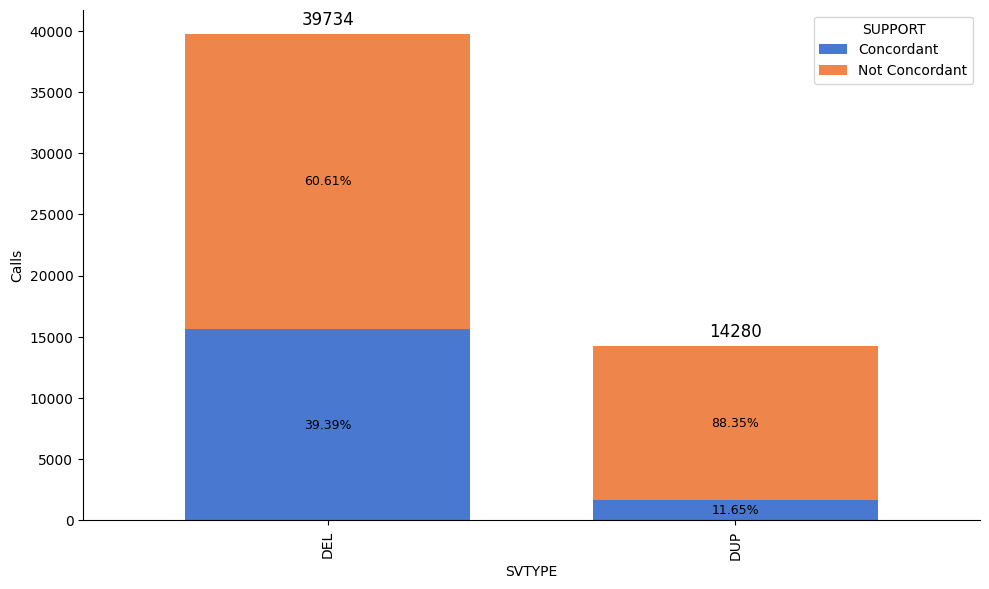

In [80]:
plot_averaged_hist(df, group_col="SVTYPE", support_col="SUPPORT", figsize=(10, 6), width=0.7)

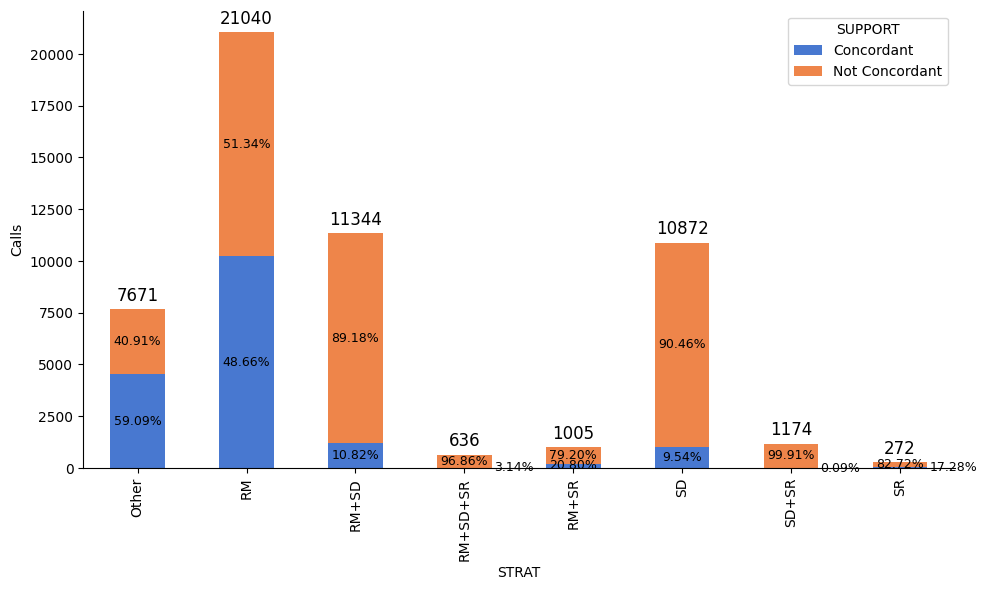

In [81]:
plot_averaged_hist(df, group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

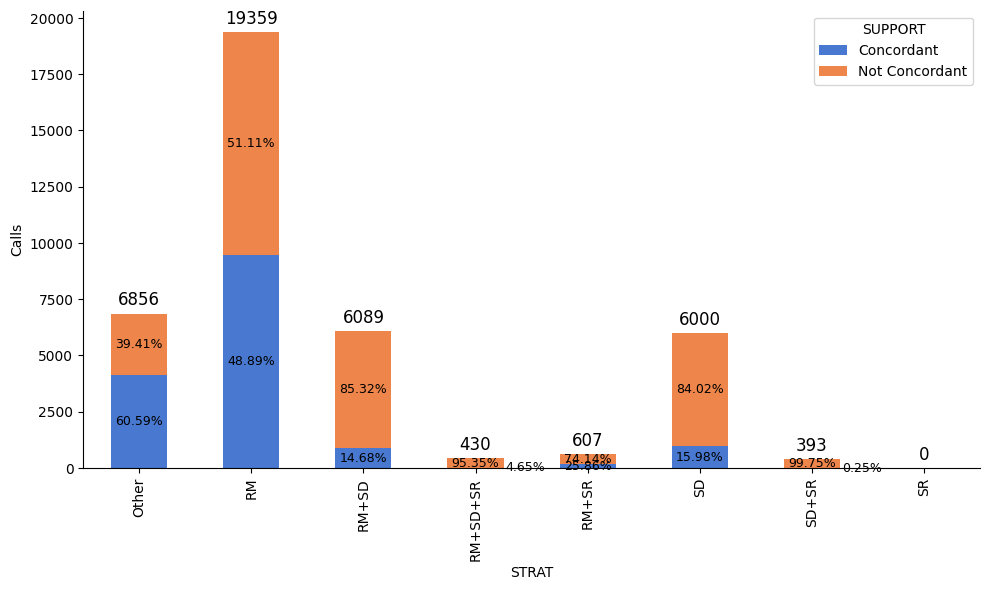

In [82]:
plot_averaged_hist(df[df['SVTYPE'] == 'DEL'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

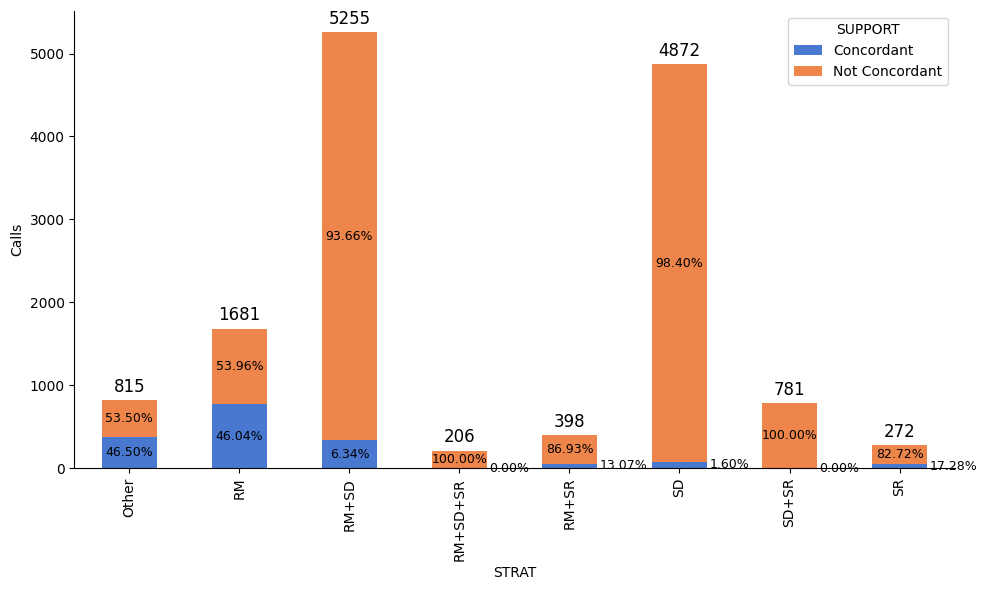

In [83]:
plot_averaged_hist(df[df['SVTYPE'] == 'DUP'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

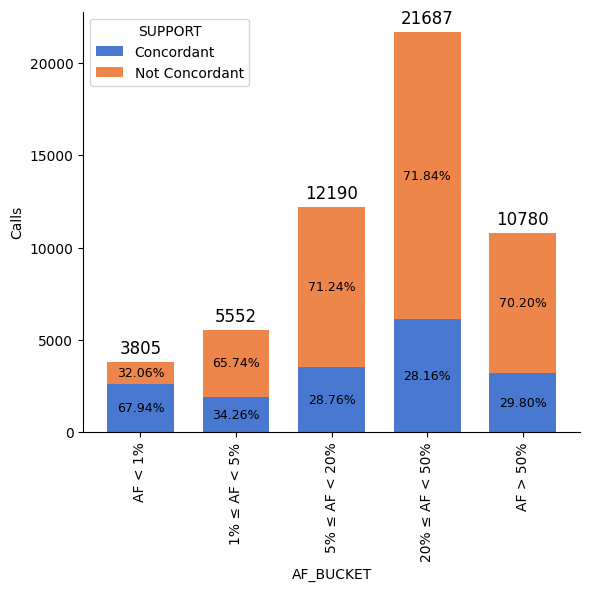

In [84]:
plot_averaged_hist(df, group_col="AF_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

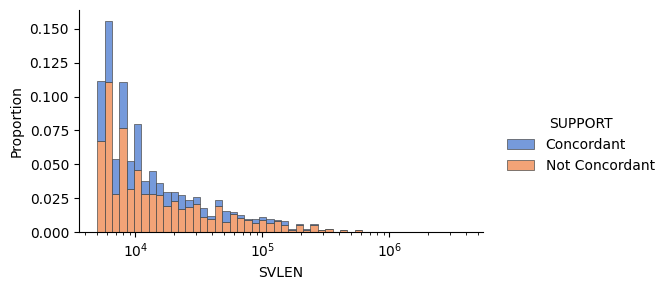

In [85]:
plot_hist(df[df['SVLEN'] > 5000], "SVLEN", hue="SUPPORT", stat="proportion", log_scale=(True, False), bins=50)

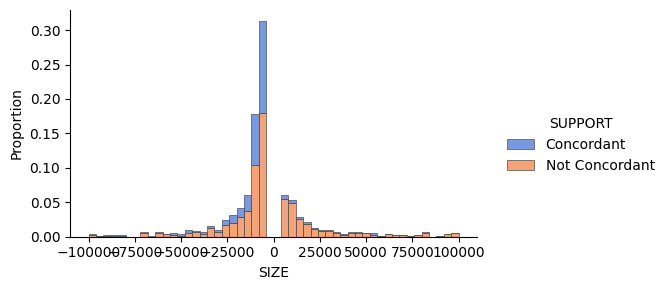

In [86]:
plot_hist(df[df['SVLEN'] > 5000], "SIZE", hue="SUPPORT", stat="proportion", binrange=(-100000, 100000), bins=50)

### Results for SVLEN > 100KB

In [87]:
display(HTML("<style>.container { width:100% !important; }</style>"))

df_100kb = df[df['SVLEN'] > 100000]

total_calls = df_100kb.shape[0]
print(f"Total Calls: {total_calls}")

total_sites = df_100kb['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df_100kb['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

print("\nLR Caller Support >= i")
table_rows = []
for i in range(0, 2):
    table_rows.append(compute_summary(df_100kb, n_samples, support_val=i, filter_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVTYPE")
table_rows = []
for svtype in df_100kb["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df_100kb, n_samples, pre_filter=True, filter_col="SVTYPE", filter_val=svtype))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVLEN")
svlen_bins = {
    "SVLEN < 500KB": df_100kb[df_100kb["SVLEN"] < 500000],
    "SVLEN 500KB-1MB": df_100kb[(df_100kb["SVLEN"] >= 500000) & (df_100kb["SVLEN"] <= 1000000)],
    "SVLEN > 1MB": df_100kb[df_100kb["SVLEN"] > 1000000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, n_samples, filter_val=label))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by STRAT")
table_rows = []
for strat in sorted(df_100kb["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
    table_rows.append(compute_summary(df_100kb, n_samples, pre_filter=True, filter_col="STRAT", filter_val=strat))
print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

Total Calls: 2799
Total Unique Sites: 277
Total Unique Samples: 235


LR Caller Support >= i
╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     11.91      │          11.91           │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     11.91      │           2.45           │       20.54%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

LR Caller Support by SVTYPE
╒══════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  SVTYPE  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞══════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   DUP    │      4.05      │           0.78           │       19.33%        │
├──────────┼───────────

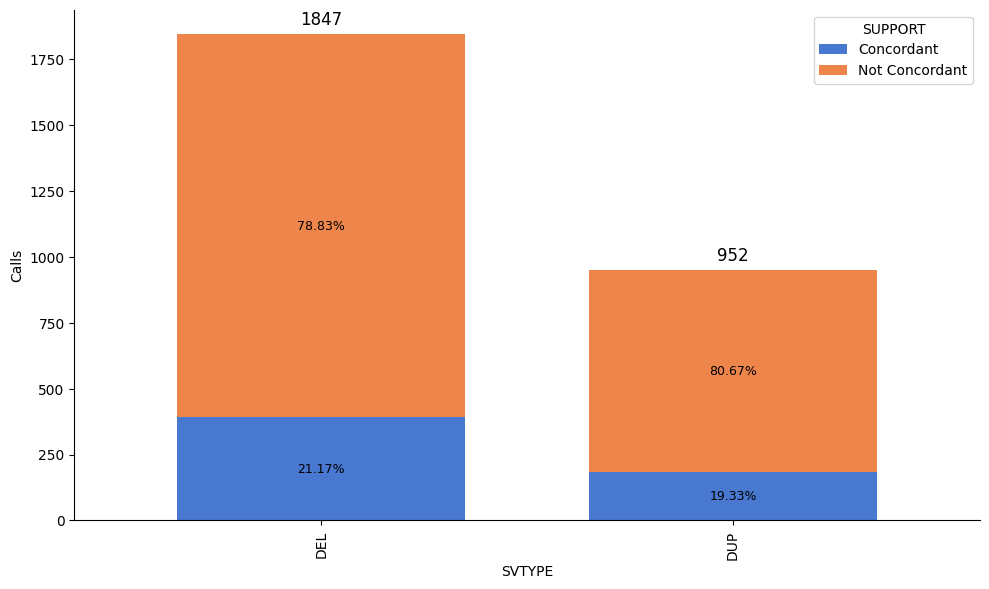

In [88]:
plot_averaged_hist(df_100kb, group_col="SVTYPE", support_col="SUPPORT", figsize=(10, 6), width=0.7)

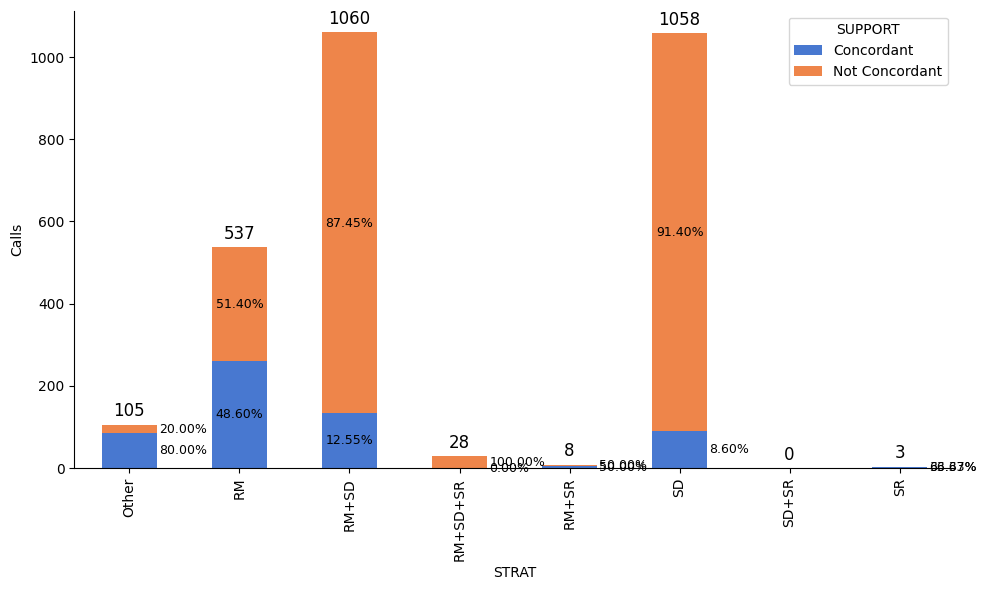

In [89]:
plot_averaged_hist(df_100kb, group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

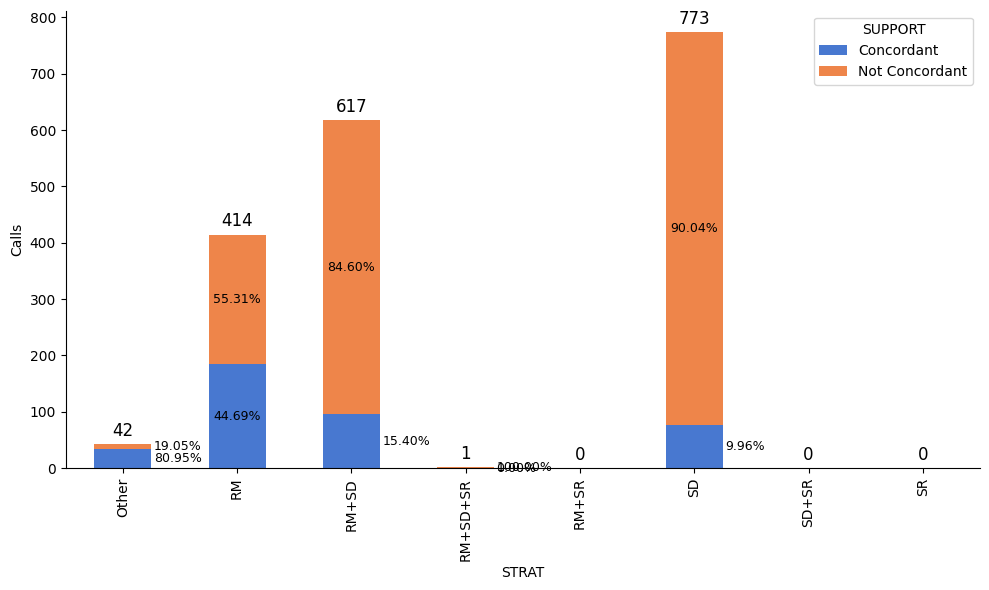

In [90]:
plot_averaged_hist(df_100kb[df_100kb['SVTYPE'] == 'DEL'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

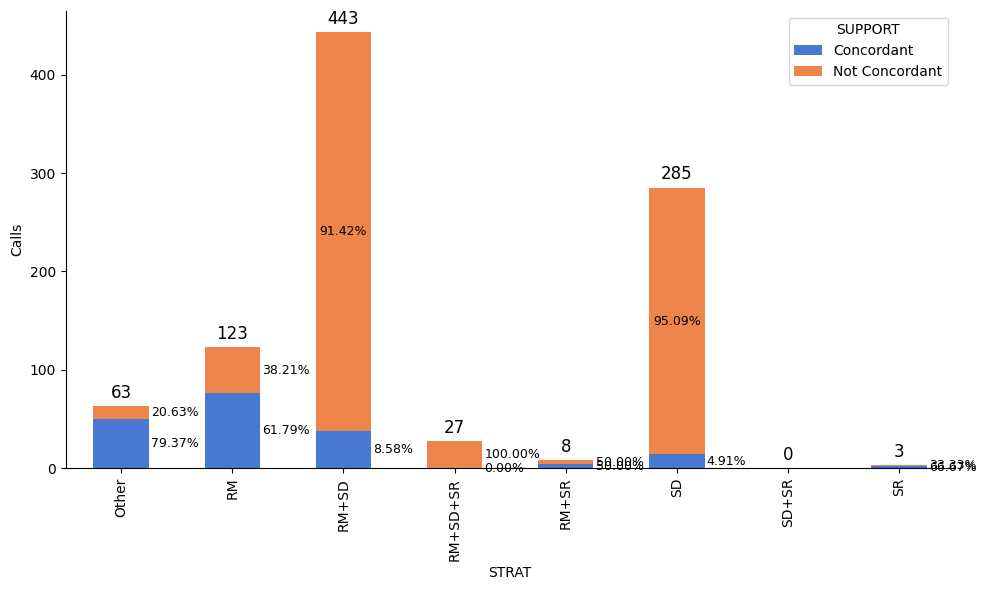

In [91]:
plot_averaged_hist(df_100kb[df_100kb['SVTYPE'] == 'DUP'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6))

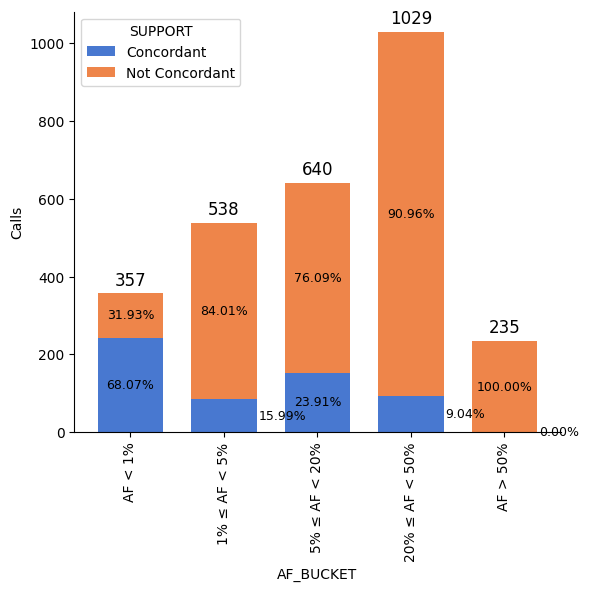

In [92]:
plot_averaged_hist(df_100kb, group_col="AF_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

### Manual Review

In [93]:
# 1. Filter by SVLEN > 100000 and STATUS == 0, then keep first occurrence per VID
df_filtered = (
    df[(df['SVLEN'] > 100000) & (df['STATUS_SITE'] == 1) & (df['STATUS_SAMPLE'] == 0)]
    .groupby('VID', as_index=False)
    .first()
    .sort_values('POS')
)

# 2. Greedily enforce a minimum distance of 1000 between POS values
selected = []
for idx, pos in zip(df_filtered.index, df_filtered['POS']):
    if not selected or abs(pos - df_filtered.loc[selected[-1], 'POS']) >= 1000:
        selected.append(idx)
df_filtered = df_filtered.loc[selected]

# 3. Sample a subset of rows
# df_filtered = df_filtered.sample(60)
df_filtered['CHROM_SORT'] = df_filtered['CHROM'].map(chrom_order)
df_filtered = df_filtered.sort_values(['CHROM_SORT', 'POS'])
result = df_filtered[['CHROM', 'POS', 'VID', 'SAMPLE', 'SVTYPE', 'SVLEN', 'STRAT', 'STATUS_SITE', 'STATUS_SAMPLE']]

result

,CHROM,POS,VID,SAMPLE,SVTYPE,SVLEN,STRAT,STATUS_SITE,STATUS_SAMPLE
6,chr1,733250,all_sample_sets.chr1.final_cleanup_DUP_chr1_3,RGP_1604_2,DUP,181576,SD,1,0
2,chr1,108239836,all_sample_sets.chr1.final_cleanup_DUP_chr1_235,RGP_2007_3,DUP,2070166,Other,1,0
3,chr1,112765836,all_sample_sets.chr1.final_cleanup_DUP_chr1_244,RGP_2222_2,DUP,428001,RM,1,0
4,chr1,121391836,all_sample_sets.chr1.final_cleanup_DUP_chr1_263,RGP_1606_1,DUP,250001,RM+SD,1,0
5,chr1,145498588,all_sample_sets.chr1.final_cleanup_DUP_chr1_276,RGP_2248_2,DUP,318001,RM+SD,1,0
...,...,...,...,...,...,...,...,...,...
69,chrX,114967276,all_sample_sets.chrX.final_cleanup_DUP_chrX_224,RGP_1396_3,DUP,196291,RM,1,0
70,chrX,116801567,all_sample_sets.chrX.final_cleanup_DUP_chrX_227,RGP_1360_1,DUP,112435,RM,1,0
71,chrX,139575355,all_sample_sets.chrX.final_cleanup_DUP_chrX_254,RGP_1396_3,DUP,134073,Other,1,0
72,chrX,149770001,all_sample_sets.chrX.final_cleanup_DUP_chrX_274,RGP_1396_3,DUP,147607,RM,1,0


### Disparity Analysis

In [94]:
df_subset = df[df['SVLEN'] >= 100000].copy()
df_subset['STRAT_SD'] = df_subset['STRAT'].str.contains('SD')

# Overall sample‐ and site‐level validation
sample_val_rate = df_subset['STATUS_SAMPLE'].mean()
print(f"Overall sample‐level validation rate: {sample_val_rate:.2%}")
site_status = df_subset.drop_duplicates(subset='VID').set_index('VID')['STATUS_SITE']
site_val_rate = site_status.mean()
print(f"\nOverall site‐level validation rate:   {site_val_rate:.2%}")

print("\n\n")

# Call‐level validation by STATUS_SITE
call_val_by_site = df_subset.groupby('STATUS_SITE')['STATUS_SAMPLE'].mean().rename('call_val_rate')
print("\nCall‐level validation rate by site status:")
print(call_val_by_site.to_frame().applymap(lambda x: f"{x:.2%}"))

# Calls-per-site summary by STATUS_SITE
calls_per_site = (
    df_subset
    .groupby('VID')
    .size()
    .rename('num_calls')
    .to_frame()
    .join(site_status.rename('STATUS_SITE'))
)
calls_summary = calls_per_site.groupby('STATUS_SITE')['num_calls'] \
    .agg(['count','mean','median','min','max'])
print("\nCalls‐per‐site summary by site status:")
print(calls_summary)

# Sample-level validation counts by STATUS_SITE
sample_summary = (
    df_subset
    .groupby('STATUS_SITE')['STATUS_SAMPLE']
    .agg(['count','sum'])
    .assign(
        validation_rate=lambda d: d['sum'] / d['count']
    )
    [['count','sum','validation_rate']]
    .rename(columns={'count':'total_calls','sum':'validated_calls'})
)
print("\nSample‐level validation counts by site status:")
print(sample_summary.apply(lambda col: col.map(lambda x: f"{x:.2%}") if col.name=='validation_rate' else col))


print("\n\n")


# Call‐level validation by STATUS_SITE × STRAT_SD
call_val = (
    df_subset
    .groupby(['STATUS_SITE', 'STRAT_SD'])['STATUS_SAMPLE']
    .mean()
    .unstack(fill_value=0)
    .rename(columns={False:'non-SD', True:'SD'})
)
print("\nCall-level validation rate by site status and STRAT contains 'SD':")
print(call_val.applymap(lambda x: f"{x:.2%}"), "\n")

# Calls-per-site summary by STATUS_SITE × STRAT_SD
calls_per_site = (
    df_subset
    .groupby(['VID', 'STRAT_SD'])
    .size()
    .rename('num_calls')
    .reset_index()
    .merge(site_status.rename('STATUS_SITE'), on='VID')
)
calls_summary = (
    calls_per_site
    .groupby(['STATUS_SITE', 'STRAT_SD'])['num_calls']
    .agg(['count','mean','median','min','max'])
    .rename(columns={'count':'sites','mean':'avg_calls'})
)
print("\nCalls-per-site summary by site status and STRAT contains 'SD':")
print(calls_summary, "\n")

# Sample-level validation counts by STATUS_SITE × STRAT_SD
sample_summary = (
    df_subset
    .groupby(['STATUS_SITE', 'STRAT_SD'])['STATUS_SAMPLE']
    .agg(total_calls='count', validated_calls='sum')
    .assign(validation_rate=lambda d: d['validated_calls']/d['total_calls'])
    .rename(columns={'total_calls':'calls','validated_calls':'valid_calls'})
)
print("\nSample-level validation by site status and STRAT contains 'SD':")
print(
    sample_summary
    .assign(validation_rate=lambda df: df['validation_rate'].map(lambda x: f"{x:.2%}"))
)

Overall sample‐level validation rate: 20.54%

Overall site‐level validation rate:   72.56%




Call‐level validation rate by site status:
            call_val_rate
STATUS_SITE              
0                   0.00%
1                  43.59%

Calls‐per‐site summary by site status:
             count       mean  median  min  max
STATUS_SITE                                    
0               76  19.473684     7.5    1  235
1              201   6.562189     2.0    1  165

Sample‐level validation counts by site status:
             total_calls  validated_calls validation_rate
STATUS_SITE                                              
0                   1480                0           0.00%
1                   1319              575          43.59%




Call-level validation rate by site status and STRAT contains 'SD':
STRAT_SD     non-SD      SD
STATUS_SITE                
0             0.00%   0.00%
1            54.08%  33.43% 


Calls-per-site summary by site status and STRAT contains 'SD

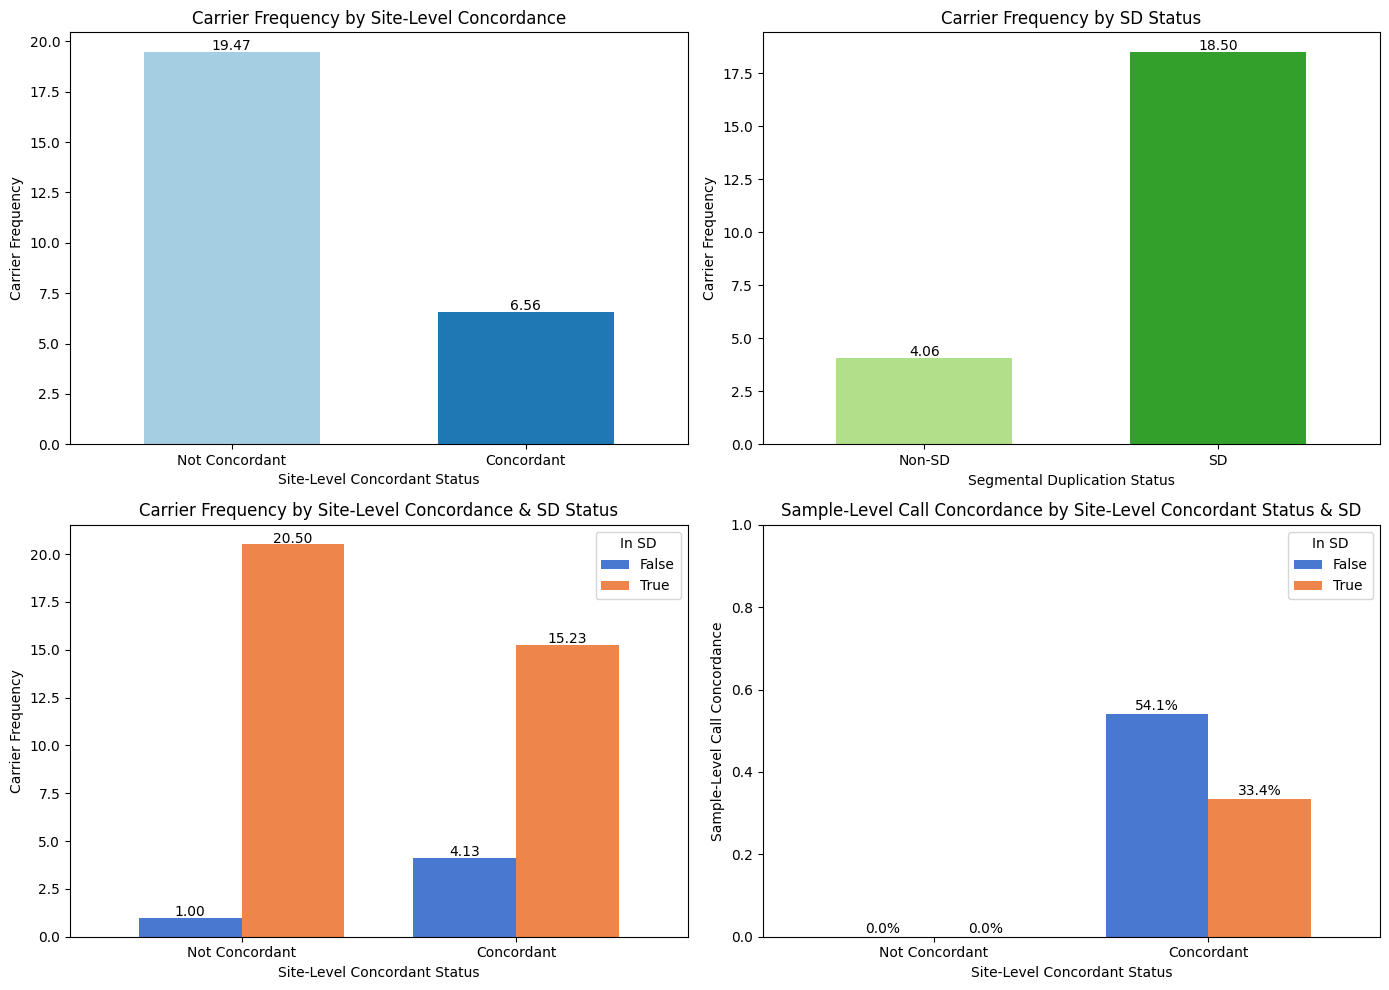

In [95]:
calls_per_site = (
    df_subset
    .groupby(['VID', 'STATUS_SITE', 'STRAT_SD'])
    .size()
    .rename('num_calls')
    .reset_index()
)

# Compute the metrics we want to plot
avg_calls_by_site = calls_per_site.groupby('STATUS_SITE')['num_calls'].mean()
avg_calls_by_strat = calls_per_site.groupby('STRAT_SD')['num_calls'].mean()
avg_calls_by_both = calls_per_site.groupby(['STATUS_SITE','STRAT_SD'])['num_calls'].mean().unstack()
call_val_by_both = df_subset.groupby(['STATUS_SITE','STRAT_SD'])['STATUS_SAMPLE'].mean().unstack()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calls per site by concordance status
avg_calls_by_site.plot(kind='bar', ax=axes[0,0], color=['#A6CEE3','#1F78B4'], width=0.6)
axes[0,0].set_title("Carrier Frequency by Site-Level Concordance")
axes[0,0].set_xticklabels(['Not Concordant','Concordant'], rotation=0)
axes[0,0].set_xlabel("Site-Level Concordant Status")
axes[0,0].set_ylabel("Carrier Frequency")
for p in axes[0,0].patches:
    axes[0,0].text(p.get_x()+p.get_width()/2, p.get_height()+0.1, f"{p.get_height():.2f}", ha='center')

# Calls per site by SD status
avg_calls_by_strat.plot(kind='bar', ax=axes[0,1], color=['#B2DF8A','#33A02C'], width=0.6)
axes[0,1].set_title("Carrier Frequency by SD Status")
axes[0,1].set_xticklabels(['Non-SD','SD'], rotation=0)
axes[0,1].set_xlabel("Segmental Duplication Status")
axes[0,1].set_ylabel("Carrier Frequency")
for p in axes[0,1].patches:
    axes[0,1].text(p.get_x()+p.get_width()/2, p.get_height()+0.1, f"{p.get_height():.2f}", ha='center')

# Calls per site by both concordance status & SD status
avg_calls_by_both.plot(kind='bar', ax=axes[1,0], width=0.75)
axes[1,0].set_title("Carrier Frequency by Site-Level Concordance & SD Status")
axes[1,0].set_xticklabels(['Not Concordant','Concordant'], rotation=0)
axes[1,0].set_xlabel("Site-Level Concordant Status")
axes[1,0].set_ylabel("Carrier Frequency")
axes[1,0].legend(title="In SD")
for p in axes[1,0].patches:
    axes[1,0].text(p.get_x()+p.get_width()/2, p.get_height()+0.1, f"{p.get_height():.2f}", ha='center')

# Concordance by both concordance status & SD status
call_val_by_both.plot(kind='bar', ax=axes[1,1], width=0.75)
axes[1,1].set_title("Sample-Level Call Concordance by Site-Level Concordant Status & SD")
axes[1,1].set_xticklabels(['Not Concordant','Concordant'], rotation=0)
axes[1,1].set_xlabel("Site-Level Concordant Status")
axes[1,1].set_ylabel("Sample-Level Call Concordance")
axes[1,1].set_ylim(0, 1)
axes[1,1].legend(title="In SD")
for p in axes[1,1].patches:
    height = p.get_height()
    axes[1,1].text(
        p.get_x() + p.get_width()/2,
        height+0.01,
        f"{height:.1%}",
        ha='center'
    )

plt.tight_layout()
plt.show()

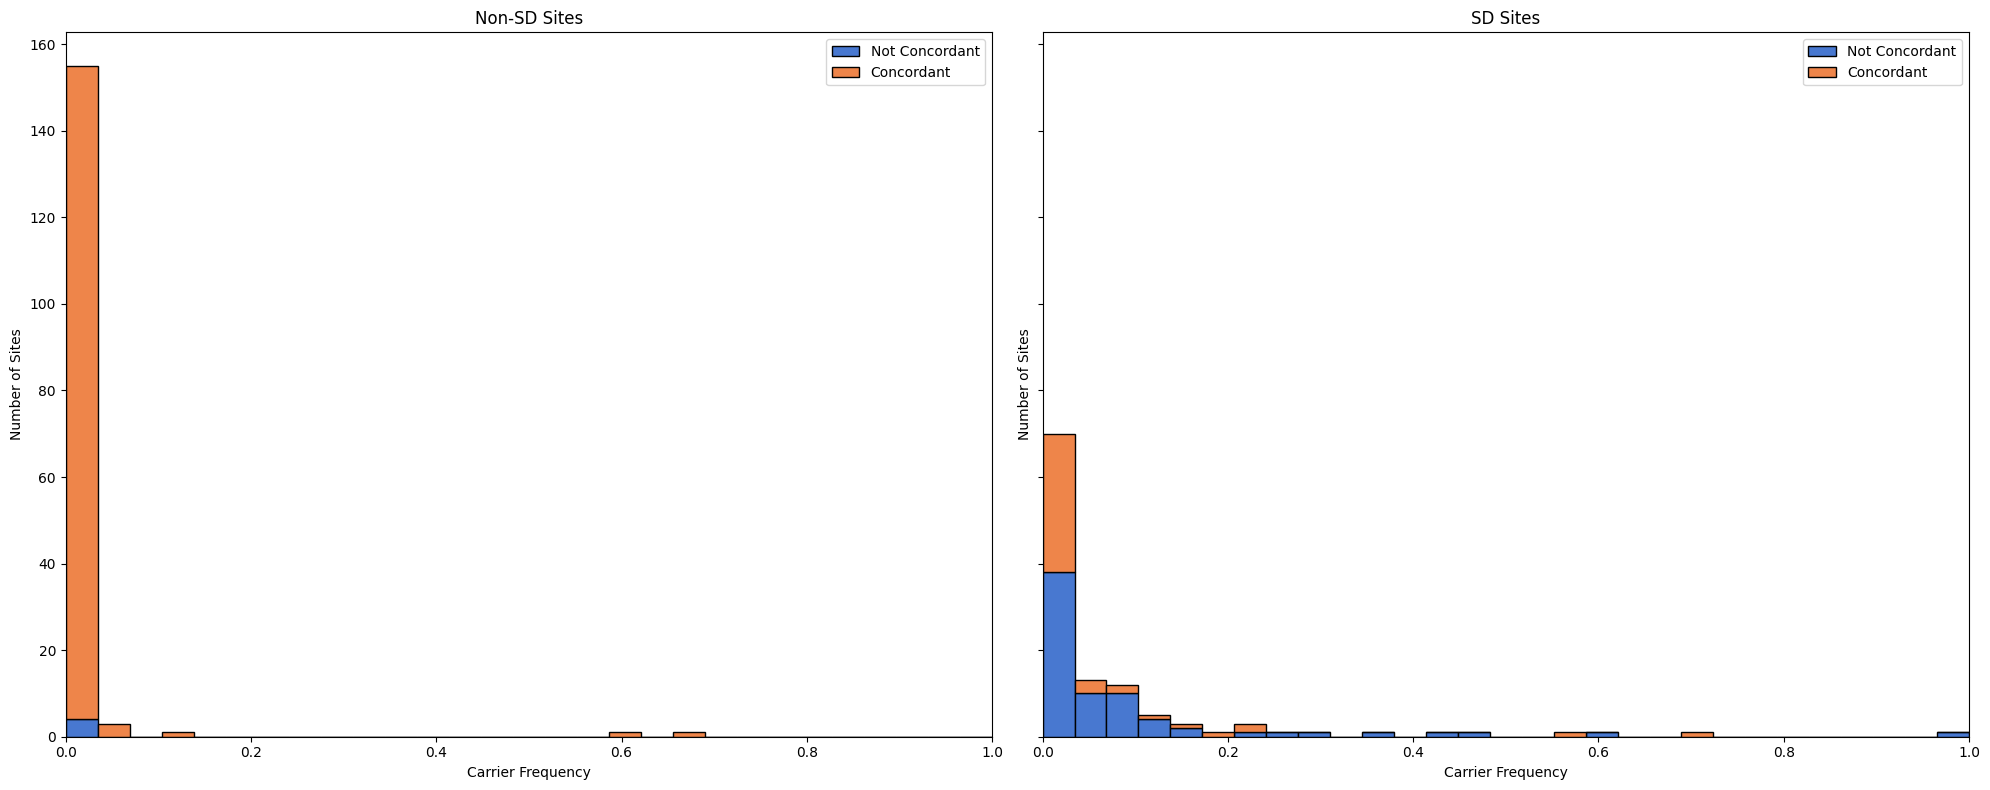

In [96]:
total_samples = df['SAMPLE'].nunique()

site_info = (
    df_subset
    .groupby('VID')
    .agg(
        n_called=('SAMPLE','nunique'),
        STATUS_SITE=('STATUS_SITE','first'),
        STRAT_SD=('STRAT_SD','first')
    )
)
site_info['carrier_freq'] = site_info['n_called'] / total_samples

bins = np.linspace(0, 1, 30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for ax, sd_flag, title in [
    (ax1, False, "Non-SD Sites"),
    (ax2, True,  "SD Sites")
]:
    subset = site_info[site_info['STRAT_SD'] == sd_flag]
    freq_invalid = subset[subset['STATUS_SITE'] == 0]['carrier_freq']
    freq_valid   = subset[subset['STATUS_SITE'] == 1]['carrier_freq']

    ax.hist(
        [freq_invalid, freq_valid],
        bins=bins,
        stacked=True,
        label=["Not Concordant", "Concordant"],
        edgecolor='black'
    )
    ax.set_title(title)
    ax.set_xlabel("Carrier Frequency")
    ax.set_xlim(0, 1)
    ax.set_ylabel("Number of Sites")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

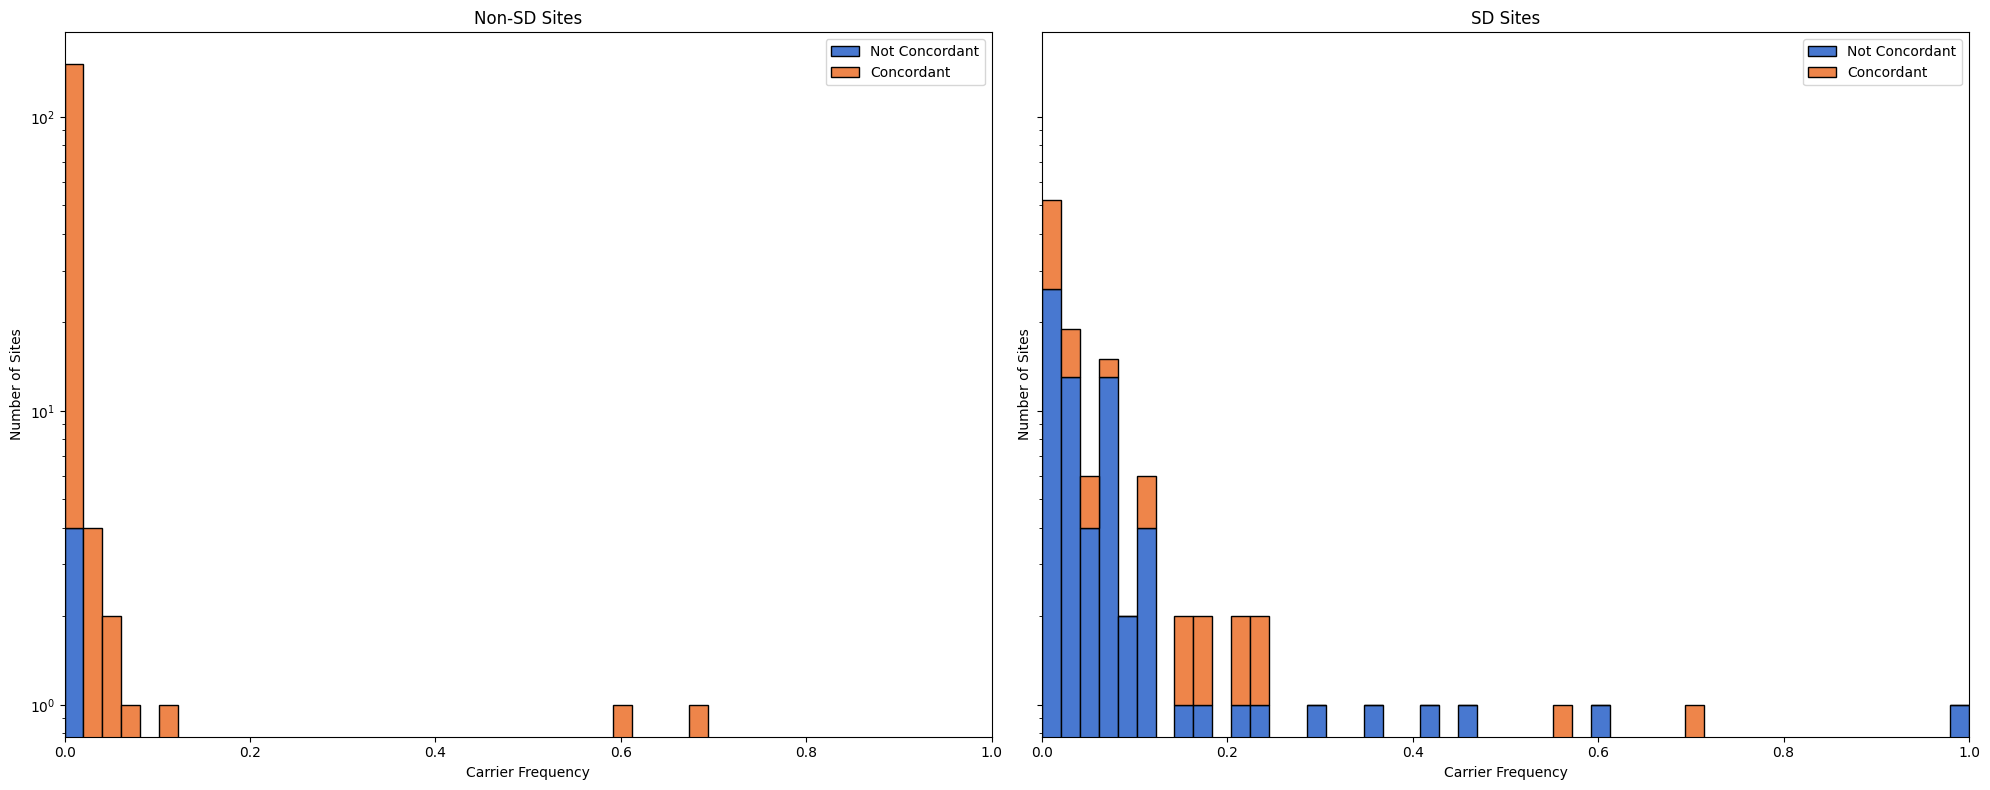

In [97]:
total_samples = df['SAMPLE'].nunique()

site_info = (
    df_subset
    .groupby('VID')
    .agg(
        n_called=('SAMPLE','nunique'),
        STATUS_SITE=('STATUS_SITE','first'),
        STRAT_SD=('STRAT_SD','first')
    )
)
site_info['carrier_freq'] = site_info['n_called'] / total_samples

bins = np.linspace(0, 1, 50)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for ax, sd_flag, title in [
    (ax1, False, "Non-SD Sites"),
    (ax2, True,  "SD Sites")
]:
    subset = site_info[site_info['STRAT_SD'] == sd_flag]
    freq_invalid = subset[subset['STATUS_SITE'] == 0]['carrier_freq']
    freq_valid   = subset[subset['STATUS_SITE'] == 1]['carrier_freq']

    ax.hist(
        [freq_invalid, freq_valid],
        bins=bins,
        stacked=True,
        label=["Not Concordant", "Concordant"],
        edgecolor='black'
    )
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel("Carrier Frequency")
    ax.set_xlim(0, 1)
    ax.set_ylabel("Number of Sites")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()